# Recommendations with IBM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

In [3]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

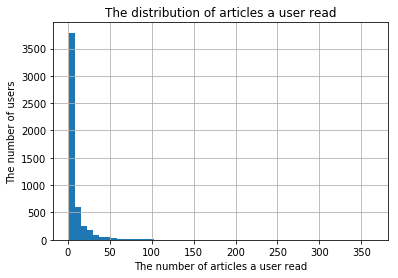

In [5]:
df['email'].value_counts().hist(bins = 50)
plt.title('The distribution of articles a user read')
plt.xlabel('The number of articles a user read')
plt.ylabel('The number of users');

In [6]:
median_val =  3  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content['article_id'].duplicated().sum()

5

In [8]:
df_content = df_content[~df_content['article_id'].duplicated()]
df_content['article_id'].duplicated().sum()

0

`3.` Find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
unique_articles

714

In [10]:
# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]
total_articles

1051

In [11]:
# The number of unique users
unique_users = df.email.nunique()
unique_users

5148

In [12]:
# The number of user-article interactions
user_article_interactions = df.shape[0]
user_article_interactions

45993

`4.` Find the most viewed **article_id**, as well as how often it was viewed.  

In [13]:
# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().values[0]
max_views

937

In [14]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = df['article_id'].value_counts().index[0]
most_viewed_article_id

1429.0

In [15]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

`1.` Return the **n** top articles ordered with most interactions as the top

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

In [17]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index[:n]
 
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.

* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 



In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)
    user_item[user_item != 0] =1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar). The returned result does not contain the provided user_id.

In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    users = user_item.index.values
    similarity = {}    
    for user in users:
        similarity[user] = np.dot(user_item.loc[user_id], user_item.loc[user])
        
    # sort by similarity, and create list of just the ids
    most_similar_users = [k for (k, v) in sorted(similarity.items(), key = lambda x: x[1], reverse = True)]
   
    # remove the own user's id
    most_similar_users.remove(user_id)  
    
    return most_similar_users # return a list of the users in order from most to least similar        

In [21]:
# Check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` The functions below returns the article recommendation to each user. 

In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    df1 = df[['article_id', 'title']].drop_duplicates()  
    article_names = df1[df1.article_id.isin(article_ids)]['title'].values
    
    return article_names # Return the article names associated with list of article ids

In [23]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id]==1].index.values
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names

In [24]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    count = 0
    recs = []
    article_ids1, article_names1 = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    for user in similar_users:
        if count < m:
            article_ids, article_names = get_user_articles(user)
            not_read = np.setdiff1d(article_ids, article_ids1)
            recs.extend(not_read)
            count += len(not_read)
        else:
            break
    recs = recs[:m]        
    return recs # return recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array([ 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'], dtype=object)

`4.` Improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. 

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity, num_interactions = [], []
    
    # compute similarity of each user to the provided user
    users = list(user_item.index.values)
    users.remove(user_id)
    
    # calculate the number of articles viewed by the user
    user_interactions = df.groupby('user_id')['title'].count()

    # create two lists
    for user in users:
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[user]))
        num_interactions.append(user_interactions.loc[user])
    
    # create a dataframe
    neighbors_df  = pd.DataFrame({'user_id':users,
                                 'similarity':similarity,
                                 'num_interactions':num_interactions})
    
    # sort values by the similarity and the number of articles read
    neighbors_df  = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [27]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    count = 0
    recs = []
    
    # get the articles read by user_id
    article_ids1, article_names1 = get_user_articles(user_id)
    
    # find the list of users who are similar to user_id
    neighbors_df = get_top_sorted_users(user_id)
    neighbors = list(neighbors_df.user_id.values)
    
    # get all the articles ranked by popularity
    top_articles = get_top_article_ids(df_content.shape[0])
    
    for user in neighbors:
        if count < m:
            article_ids, article_names = get_user_articles(user) # get articles read by the neighbors
            not_read = np.setdiff1d(article_ids, article_ids1) # remove the articles read by user_id
            sorted_not_read = [x for x in top_articles if x in not_read] # sort the articles based on popularity
            recs.extend(sorted_not_read) # add the articles to recs
            count += len(sorted_not_read)
        else:
            break
    recs = recs[:m]    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'putting a human face on machine learning'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'model bike sharing data with spss'
 'analyze accident reports on amazon emr spark'
 'movie recommender system with spark machine learning']


`5.` Test the functions.

In [29]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

`6.` Given a new user, the "get_top_article_ids" function can be used to make recommendations. A better way to make recommendations might be knowledge-based. If the new user selects the topics of interest, we can use that to make recommendations. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [31]:
new_user_recs

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Build matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Set up for the user_article matrix. 

In [32]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [33]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

SVD can be used here, because there is no NaN values. If there are NaN values, funkSVD will be used instead. 

In [34]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [35]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

`3.` As the number of latent features increases, the error rate on making predictions for the 1 and 0 values in the user-item matrix decreases.  The graph below shows how the accuracy improves as we increase the number of latent features.

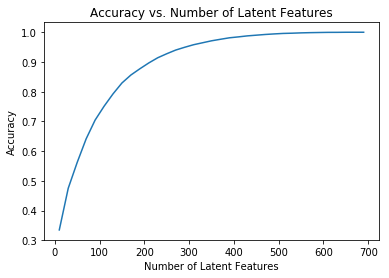

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we will split the dataset into a training and test set of data, as shown in the cell below.  

In [37]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)   
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique() 
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [38]:
# Number of users we can make predictions for in the test set
len(set(user_item_train.index) & set(user_item_test.index))

20

In [39]:
# Number of users in the test set we are not able to make predictions for because of the cold start problem
len(test_idx) - len(set(user_item_train.index) & set(user_item_test.index))

662

In [40]:
# Number of articles we can make predictions for in the test set
user_item_test.shape[1]

574

In [41]:
# Number of articles in the test set we are not able to make predictions for because of the cold start problem
len(test_arts) - user_item_test.shape[1]

0

`5.` Use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that can be predicted using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.  

In [42]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [43]:
train_idx = user_item_train.index

In [44]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
s_test = s_train
user_item_test = user_item_test[user_item_test.index.isin(train_idx)]
u_test.shape, s_test.shape, vt_test.shape, user_item_test.shape

((20, 714), (714,), (714, 574), (20, 574))

In [45]:
def plot_accuracy(user_item_matrix, u, s, vt):

    num_latent_feats = np.arange(10,vt.shape[0],20)
    sum_errs, f1_scores = [], []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)

    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0], label = 'Accuracy');
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Latent Features');

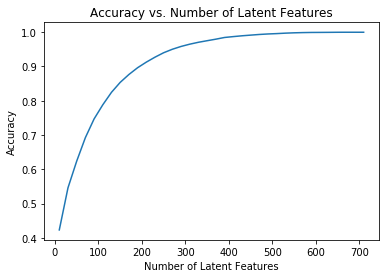

In [46]:
plot_accuracy(user_item_train, u_train, s_train, vt_train)

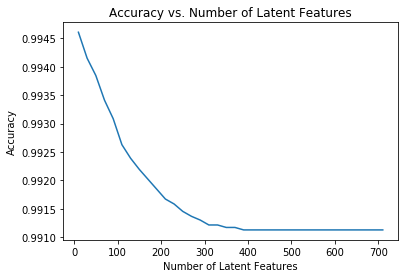

In [47]:
plot_accuracy(user_item_test, u_test, s_test, vt_test)

`6.` Given the circumstances of the results, how to determine if the recommendations are an improvement to how users currently find articles? 

Based on plot, the accuracy was high. It can be expected since most values are zeros. We can perform A/B testing to see whether the recommendations make a difference. The evaluation metric couldf be the number of articles read or commented over a fixed time period. 